In [69]:
import os
import logging
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans, vq
from scipy.stats import skew, norm, kurtosis

logger = logging.getLogger()

In [70]:
PATH = os.path.join(os.getcwd(), 'runs', 'detect', 'Output (n)', 'weights', 'best.pt')
model = YOLO(PATH)

In [3]:

# Get the number of layers in the model
num_layers = len(list(model.modules())) - 1

print("Number of layers in the model:", num_layers)

Number of layers in the model: 225


In [5]:
def extract_features(image_path, model, layer_index):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((128 ,128)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    featuers = []
    def hook_fn(module, input, output):
        featuers.append(output)
    
    handle = model.model.model[layer_index].register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_batch)

    handle.remove()
    return featuers[0]

In [71]:
image_dir = os.path.join(os.getcwd(), 'Clean', 'train', 'images')
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]

In [7]:
features_list = []
for image_path in image_paths:
    features = extract_features(image_path, model, 2)
    features_list.append(features.flatten().numpy())


0: 128x128 (no detections), 22.9ms
Speed: 0.0ms preprocess, 22.9ms inference, 4.3ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 2 Tumors, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.3ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 

KeyboardInterrupt: 

In [10]:
# Dimensionality reduction using PCA
features_array = np.array(features_list)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_array)

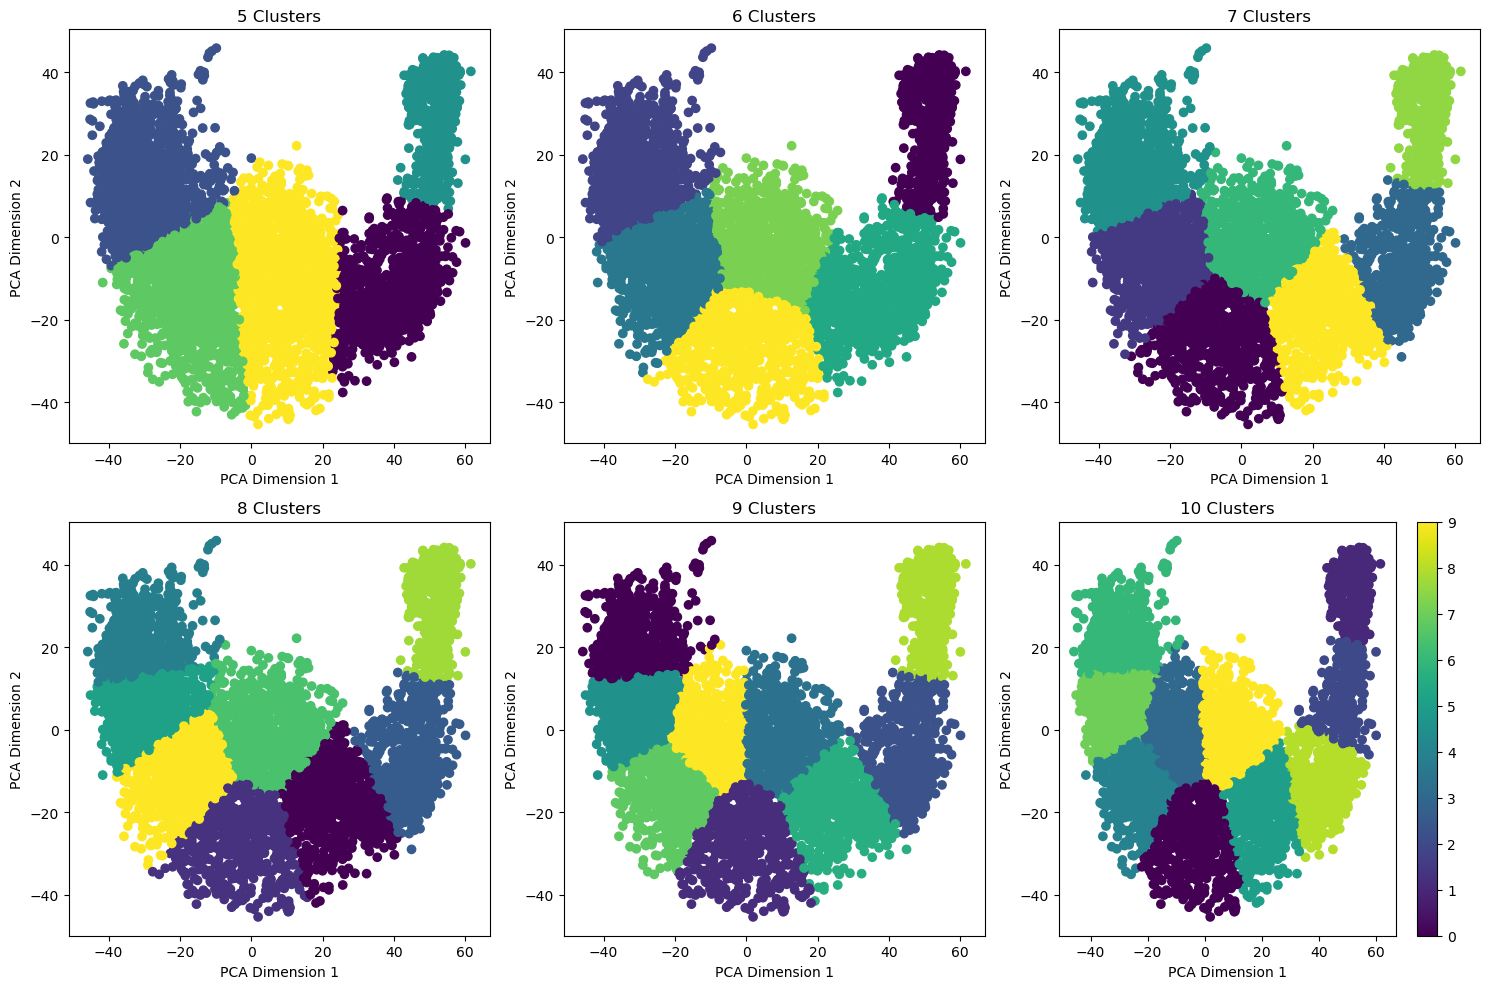

In [11]:
cluster_numbers = range(5, 11)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, n_clusters in enumerate(cluster_numbers):
    centroids, _ = kmeans(features_pca, n_clusters)
    clusters, _ = vq(features_pca, centroids)
    scatter = axs[i].scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
    axs[i].set_title(f'{n_clusters} Clusters')
    axs[i].set_xlabel('PCA Dimension 1')
    axs[i].set_ylabel('PCA Dimension 2')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.colorbar(scatter, ax=axs[i], orientation='vertical')

plt.tight_layout()
plt.show()



Text(0, 0.5, 'PCA Dimension 2')

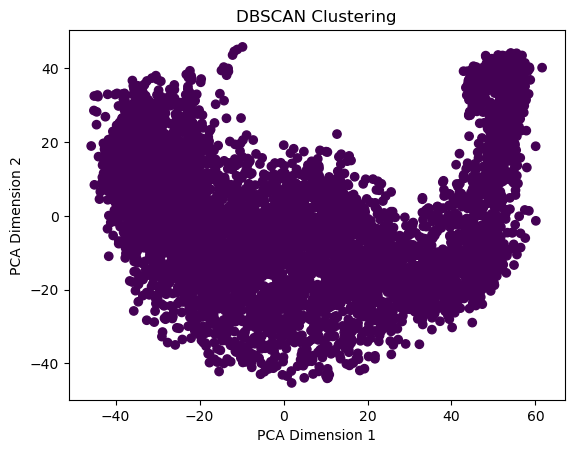

In [12]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(features_pca)
labels = db.labels_

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')


In [13]:
# Dimensionality reduction using PCA
features_array = np.array(features_list)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

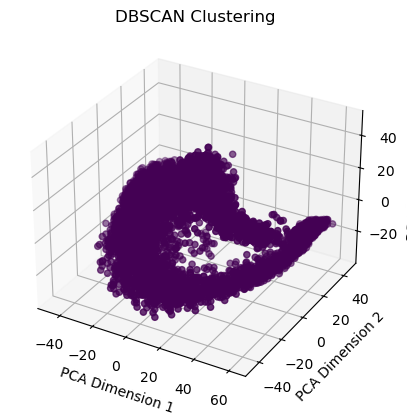

In [14]:
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

db = DBSCAN(eps=0.3, min_samples=10).fit(features_pca)
labels = db.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=labels, cmap='viridis')

ax.set_title('DBSCAN Clustering')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')

plt.show()

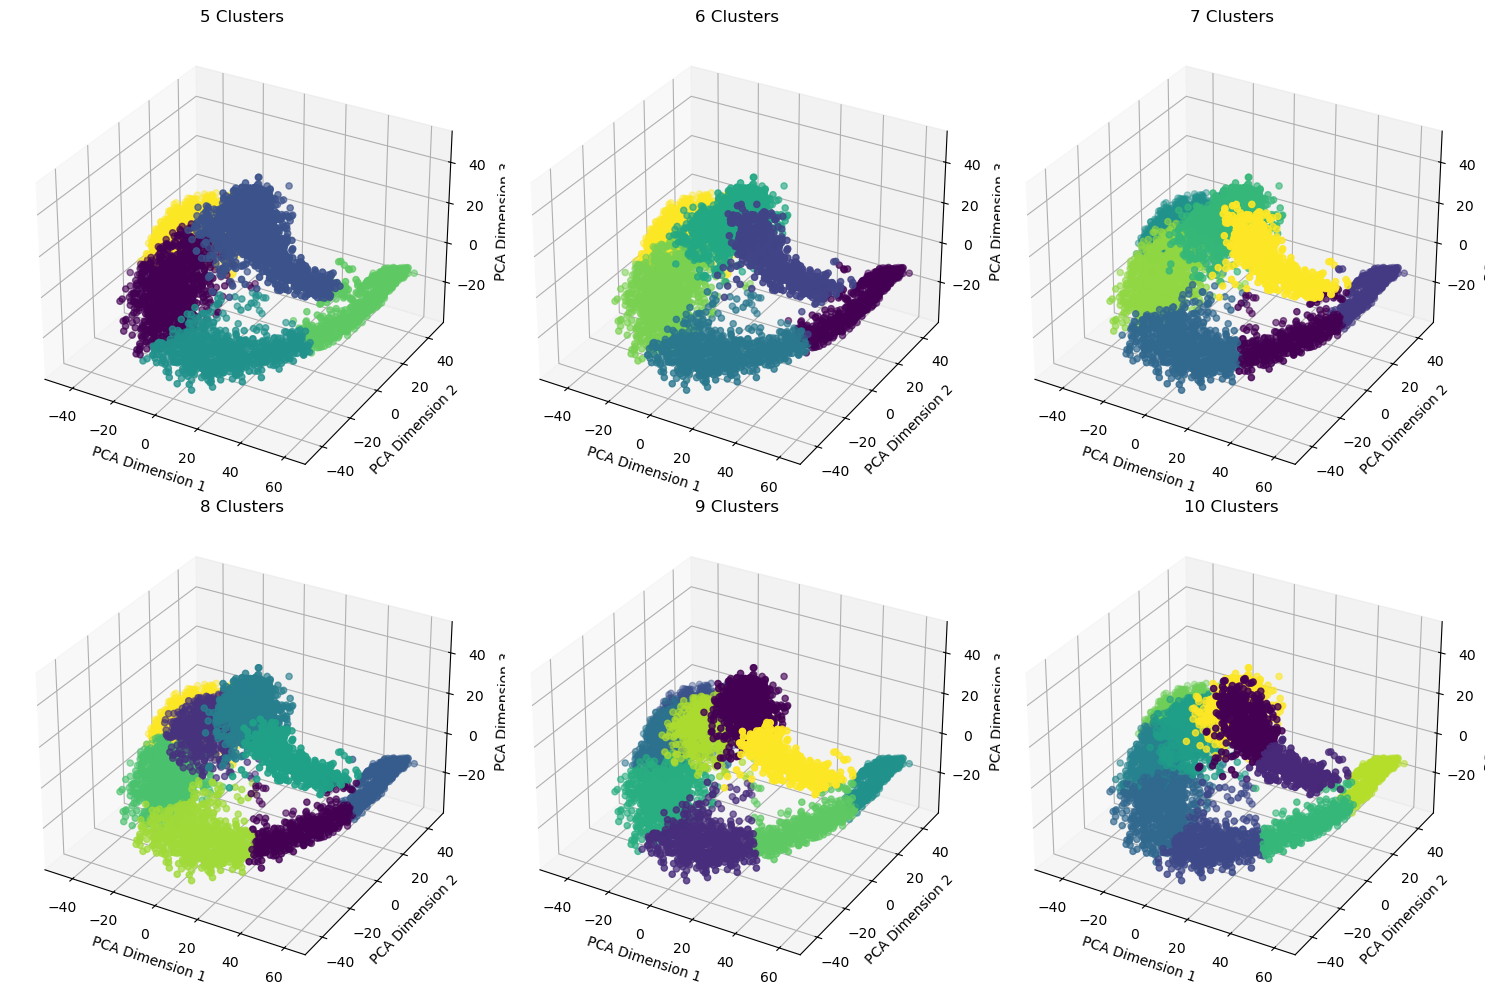

In [15]:
cluster_numbers = range(5, 11)
fig = plt.figure(figsize=(15, 10))

for i, n_clusters in enumerate(cluster_numbers):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    centroids, _ = kmeans(features_pca, n_clusters)
    clusters, _ = vq(features_pca, centroids)
    scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=clusters, cmap='viridis')
    ax.set_title(f'{n_clusters} Clusters')
    ax.set_xlabel('PCA Dimension 1')
    ax.set_ylabel('PCA Dimension 2')
    ax.set_zlabel('PCA Dimension 3')

plt.tight_layout()
plt.show()


In [72]:
images = [torchvision.io.read_image(img) for img in image_paths]

images[0].shape

torch.Size([3, 132, 139])

In [9]:
images[0]

tensor([[[12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         ...,
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12]],

        [[12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         ...,
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12]],

        [[12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         ...,
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12],
         [12, 12, 12,  ..., 12, 12, 12]]], dtype=torch.uint8)

In [73]:
color_features = pd.DataFrame()

In [74]:
channels = {'R': 0, 'G': 1, 'B': 2}

for channel in channels:
    color_features[f'Mean ({channel})'] = [np.mean(img[channels[channel]].numpy()) for img in images]
    color_features[f'Variance ({channel})'] = [np.var(img[channels[channel]].numpy()) for img in images]
    color_features[f'Skewness ({channel})'] = [(skew(img[channels[channel]].numpy().flatten())) for img in images]
    color_features[f'Kurtosis ({channel})'] = [(kurtosis(img[channels[channel]].numpy().flatten())) for img in images]
    
color_features.head()

Mean (R)  Variance (R)  Skewness (R)  Kurtosis (R)   Mean (G)  \
0  56.679529   1792.590344      0.829214      0.510809  46.853009   
1  54.102027    896.591400      0.580461      1.726535  43.181982   
2  25.393067   2260.559036      2.359008      4.737492  20.034173   
3  39.475147   1085.556446      1.772970      4.751434  36.579627   
4  36.662961    932.337244      1.768621      4.090157  36.658382   

   Variance (G)  Skewness (G)  Kurtosis (G)   Mean (B)  Variance (B)  \
0   1073.825080      1.766189      5.150980  52.974548   1121.660732   
1    591.858914      1.925910      7.824217  44.260900    602.551890   
2   1824.275538      3.117653      9.286242  22.309789   2047.559906   
3    953.406947      2.401245      8.124411  38.269621    974.255460   
4   1132.281052      2.105872      4.719021  33.766623    831.058790   

   Skewness (B)  Kurtosis (B)  
0      0.984376      2.541535  
1      1.392128      5.586340  
2      2.873520      7.823909  
3      1.886819      5.330601  
4      2.057511      5.063972

In [75]:
color_features.describe()

Mean (R)  Variance (R)  Skewness (R)  Kurtosis (R)     Mean (G)  \
count  6745.000000   6745.000000   6745.000000   6745.000000  6745.000000   
mean     45.943485   1436.062492      1.431637      3.624780    38.595578   
std      17.641495    557.735723      1.023968      6.629294    12.486363   
min       0.743242     60.021442     -0.664306     -1.263552     0.691956   
25%      31.787225   1053.296311      0.652534      0.345238    28.761009   
50%      44.996948   1340.903898      1.342620      2.456277    38.643013   
75%      57.824722   1722.245334      2.105343      5.317636    47.548616   
max     107.764497   4943.544663     14.970072    262.375894    81.833224   

       Variance (G)  Skewness (G)  Kurtosis (G)     Mean (B)  Variance (B)  \
count   6745.000000   6745.000000   6745.000000  6745.000000   6745.000000   
mean    1167.886736      2.069334      6.128465    40.785047   1116.411216   
std      506.236534      0.800598      6.820085    14.397810    459.509843   
min       56.663992      0.007767     -0.493650     0.769021     61.356830   
25%      841.930800      1.562119      3.020065    29.565893    824.531865   
50%     1075.956847      1.975843      5.007275    40.547417   1052.349245   
75%     1383.664486      2.486576      7.692595    51.132549   1317.178557   
max     4944.583139     15.304033    272.603643    93.963647   5390.211401   

       Skewness (B)  Kurtosis (B)  
count   6745.000000   6745.000000  
mean       1.776094      5.227017  
std        0.887864      6.468309  
min       -0.178237     -0.860950  
25%        1.165901      2.162687  
50%        1.744454      4.166448  
75%        2.312783      6.811370  
max       14.758983    255.636887

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

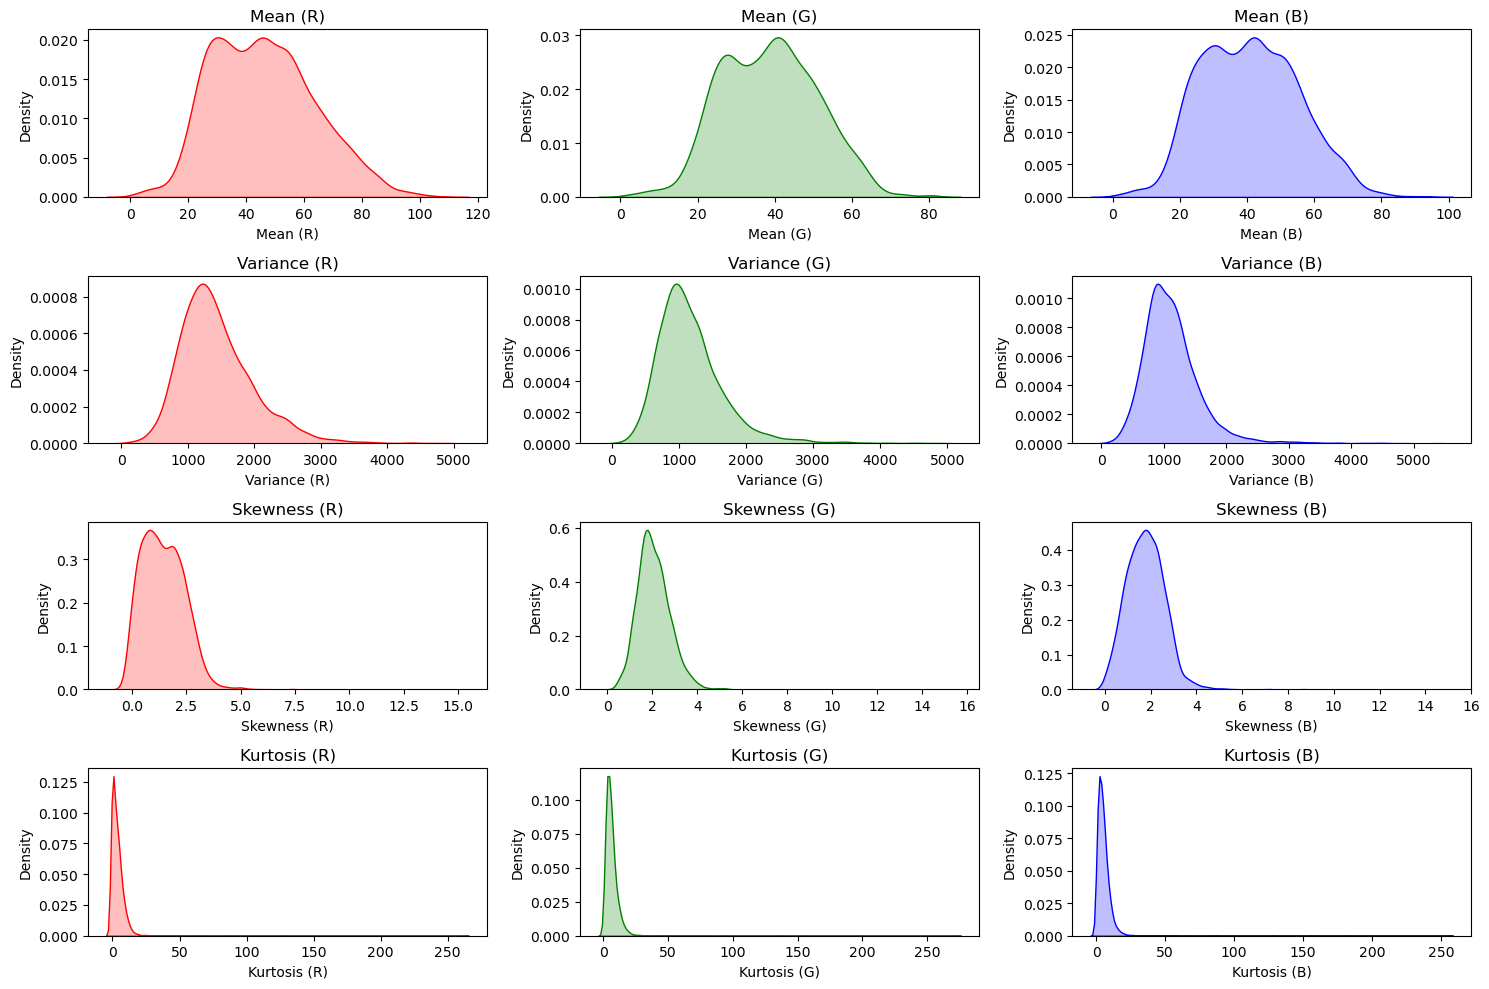

In [77]:
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
for channel in channels:
    lower = channel.lower()
    for i, stat in enumerate(['Mean', 'Variance', 'Skewness', 'Kurtosis']):
        ax = axes[i, channels[channel]]
        sns.kdeplot(color_features[f'{stat} ({channel})'], color=lower, ax=ax, fill=True)
        ax.set_title(f'{stat} ({channel})')
        
        fig.tight_layout()

TODO: Check about the `Kurtosis` feature and maybe visualize outliers from the edges of the plots.

array([[<Axes: title={'center': 'Mean (R)'}>, <Axes: title={'center': 'Variance (R)'}>, <Axes: title={'center': 'Skewness (R)'}>],
       [<Axes: title={'center': 'Kurtosis (R)'}>, <Axes: title={'center': 'Mean (G)'}>, <Axes: title={'center': 'Variance (G)'}>],
       [<Axes: title={'center': 'Skewness (G)'}>, <Axes: title={'center': 'Kurtosis (G)'}>, <Axes: title={'center': 'Mean (B)'}>],
       [<Axes: title={'center': 'Variance (B)'}>, <Axes: title={'center': 'Skewness (B)'}>, <Axes: title={'center': 'Kurtosis (B)'}>]], dtype=object)

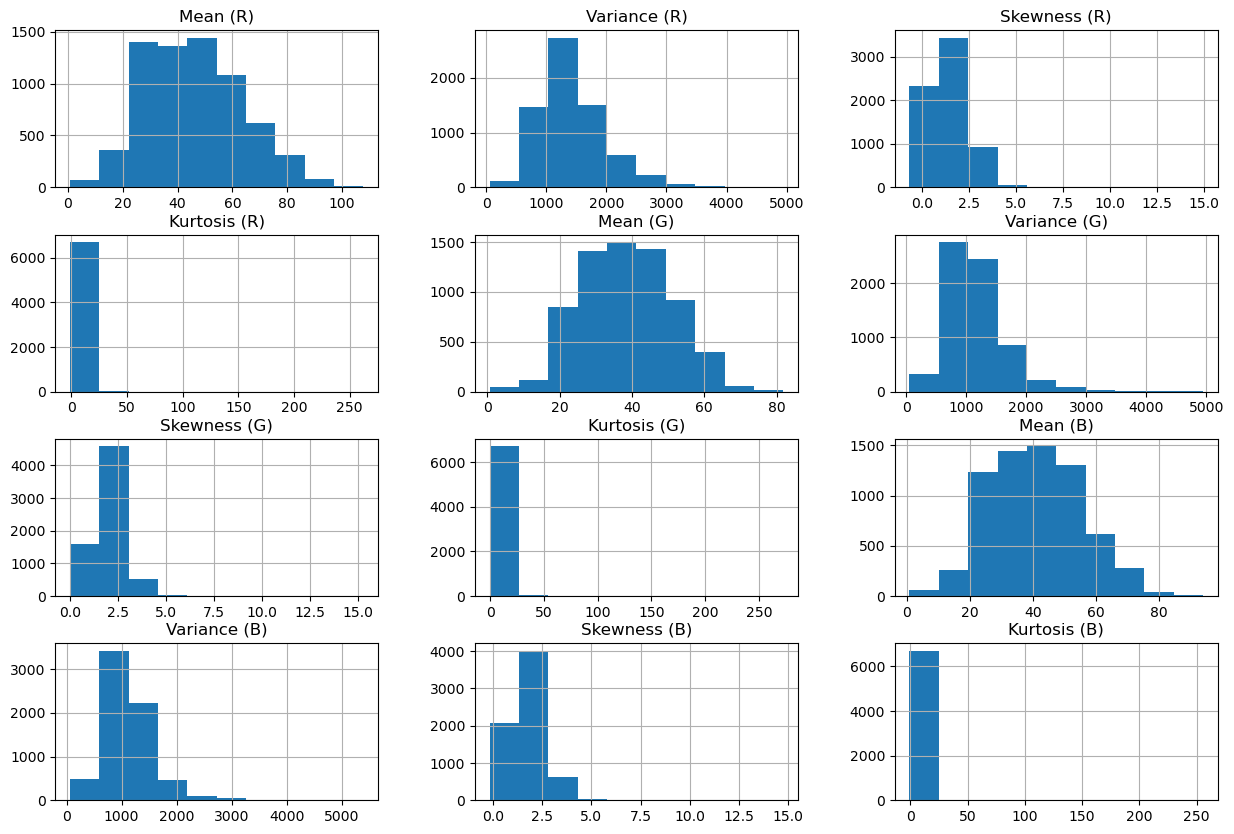

In [78]:
color_features.hist(figsize=(15, 10))

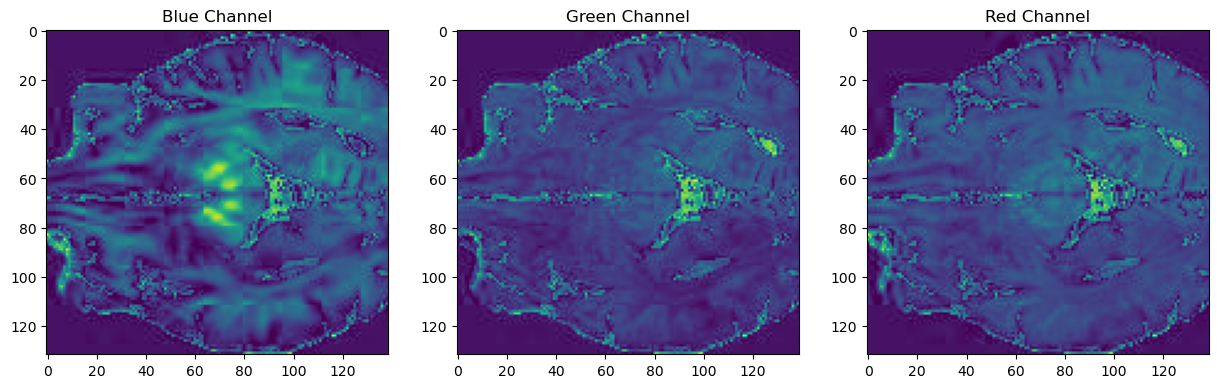

In [79]:
image = Image.open(image_paths[0])
blue, green, red = image.split()

# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)

plt.title("Blue Channel")
plt.imshow(blue)

fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)

fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)

plt.show()

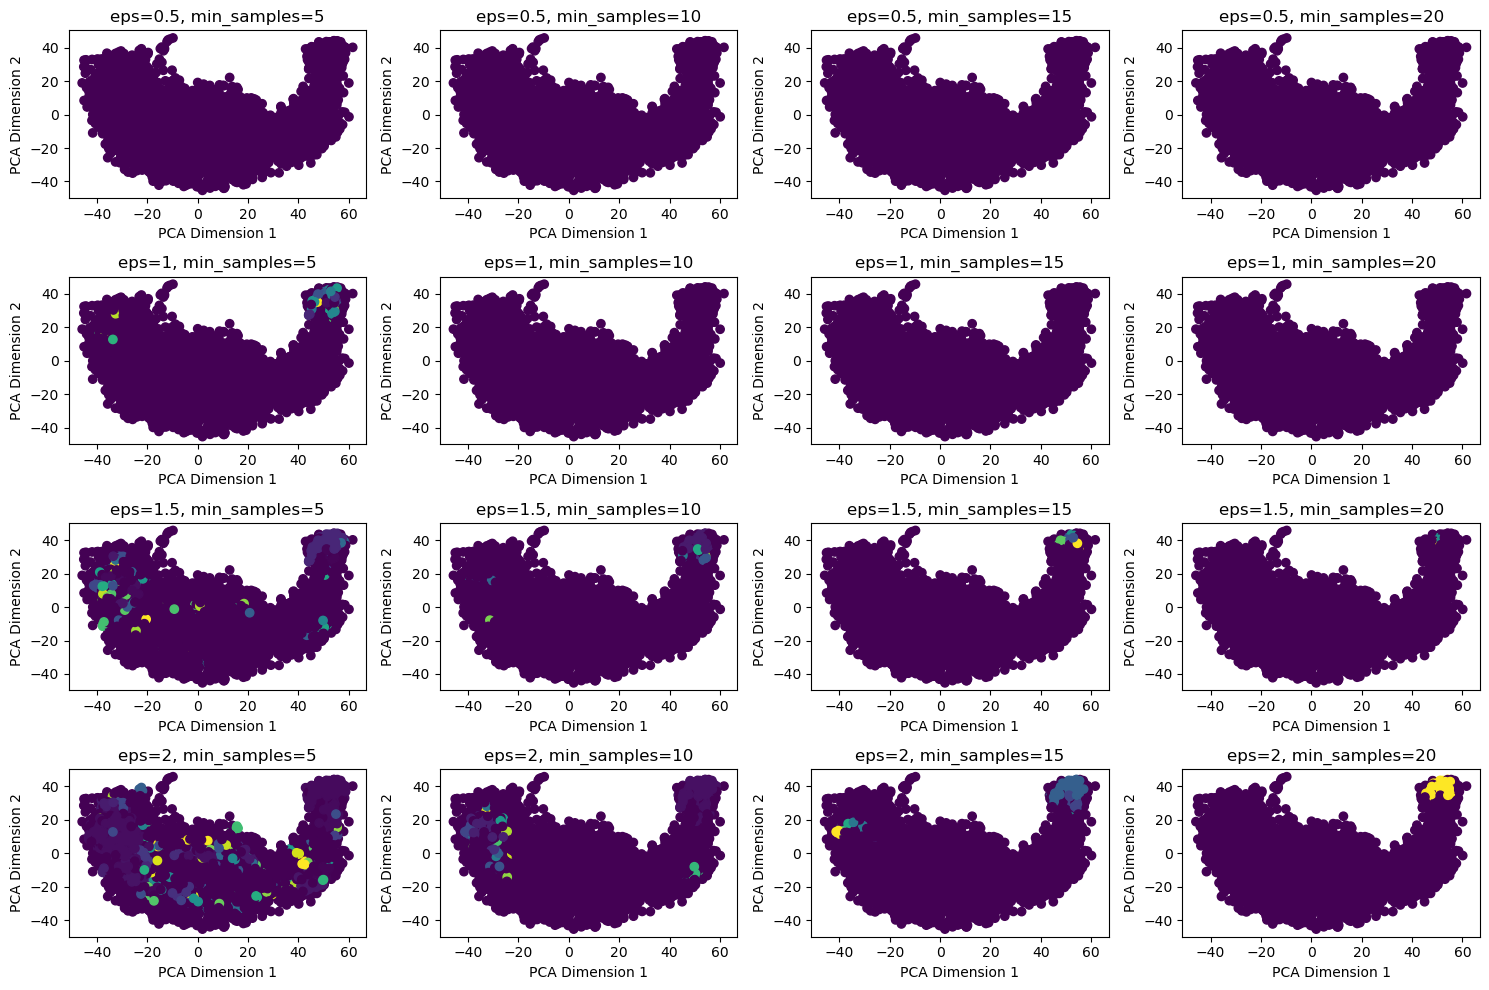

In [23]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Experiment with different eps and min_samples values
eps_values = [0.5, 1, 1.5, 2]
min_samples_values = [5, 10, 15, 20]

fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features_pca)
        axs[i, j].scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
        axs[i, j].set_title(f'eps={eps}, min_samples={min_samples}')
        axs[i, j].set_xlabel('PCA Dimension 1')
        axs[i, j].set_ylabel('PCA Dimension 2')

plt.tight_layout()
plt.show()

## Haar Wavelet Transform (HWT)

In [34]:
import pywt

def apply_hwt_to_color_images(images):
    features = []
    for image in images:
        channel_features = []
        # Iterate over each color channel
        for channel in range(image.shape[0]):
            # Apply Haar Wavelet Transform to each channel
            coeffs = pywt.dwt2(image[channel], 'haar')
            cA, (cH, cV, cD) = coeffs
            
            # Example: using approximation coefficients from each channel
            channel_features.append(cA.flatten())
        
        # Concatenate features from all channels
        features.append(np.concatenate(channel_features))
    
    return features

# Assuming 'images' is a list of numpy arrays representing your images
haar_features = apply_hwt_to_color_images([img.numpy() for img in images])
haar_features = np.array(haar_features)

In [35]:
haar_features.shape

(6745, 13860)

1. **Mean (HWT Approximation Mean)**: The mean of the approximation coefficients represents the average intensity of the smoothed image (after applying HWT). It gives you an idea of the overall brightness or darkness of the image. A higher mean could indicate a generally brighter image, while a lower mean could indicate a darker image.
2. **Variance (HWT Approximation Variance)**: The variance measures the spread of the approximation coefficients around the mean. It tells you how much the pixel intensities vary from the average intensity. A high variance indicates that the image has a wide range of intensities (high contrast), while a low variance indicates that the intensities are more uniform (low contrast).
3. **Skewness (HWT Approximation Skewness)**: Skewness measures the asymmetry of the distribution of the approximation coefficients. A positive skewness indicates that the distribution has a long tail on the right side, suggesting that there are a few very bright pixels. A negative skewness indicates a long tail on the left side, suggesting there are a few very dark pixels. A skewness close to zero suggests a symmetric distribution of intensities.
4. **Kurtosis (HWT Approximation Kurtosis)**: Kurtosis measures the "peakedness" of the distribution of the approximation coefficients. A high kurtosis indicates that the distribution has heavy tails and a sharp peak, suggesting that there are many pixels with similar intensities. A low kurtosis indicates a flatter distribution with lighter tails, suggesting a wider range of intensities.

By analyzing these statistical measures, you can gain insights into the characteristics of your images. For example, images with high variance and kurtosis might contain more detailed textures or edges, while images with low variance and near-zero skewness might be more uniform and smooth. These insights can be valuable for tasks such as image classification, where different classes of images might exhibit distinct statistical patterns in their wavelet coefficients.

In [40]:
color_features['HWT Approximation Mean'] = [np.mean(img) for img in haar_features]
color_features['HWT Approximation Variance'] = [np.var(img) for img in haar_features]
color_features['HWT Approximation Skewness'] = [skew(img.flatten()) for img in haar_features]
color_features['HWT Approximation Kurtosis'] = [kurtosis(img.flatten()) for img in haar_features]
color_features.head()

Mean (R)  Variance (R)  Skewness (R)   Mean (G)  Variance (G)  \
0  56.679529   1792.590344      0.829214  46.853009   1073.825080   
1  54.102027    896.591400      0.580461  43.181982    591.858914   
2  25.393067   2260.559036      2.359008  20.034173   1824.275538   
3  39.475147   1085.556446      1.772970  36.579627    953.406947   
4  36.662961    932.337244      1.768621  36.658382   1132.281052   

   Skewness (G)   Mean (B)  Variance (B)  Skewness (B)  \
0      1.766189  52.974548   1121.660732      0.984376   
1      1.925910  44.260900    602.551890      1.392128   
2      3.117653  22.309789   2047.559906      2.873520   
3      2.401245  38.269621    974.255460      1.886819   
4      2.105872  33.766623    831.058790      2.057511   

   HWT Approximation Mean  HWT Approximation Variance  \
0              104.191955                 3990.901339   
1               94.325289                 2139.949617   
2               44.885462                 6649.983508   
3               76.156277                 2719.307829   
4               71.192569                 2643.224209   

   HWT Approximation Skewness  HWT Approximation Kurtosis  
0                    0.903617                    1.657308  
1                    0.697416                    1.706043  
2                    2.556456                    6.187533  
3                    1.434873                    3.296819  
4                    1.736027                    3.988811

array([[<Axes: title={'center': 'HWT Approximation Mean'}>, <Axes: title={'center': 'HWT Approximation Variance'}>],
       [<Axes: title={'center': 'HWT Approximation Skewness'}>, <Axes: title={'center': 'HWT Approximation Kurtosis'}>]], dtype=object)

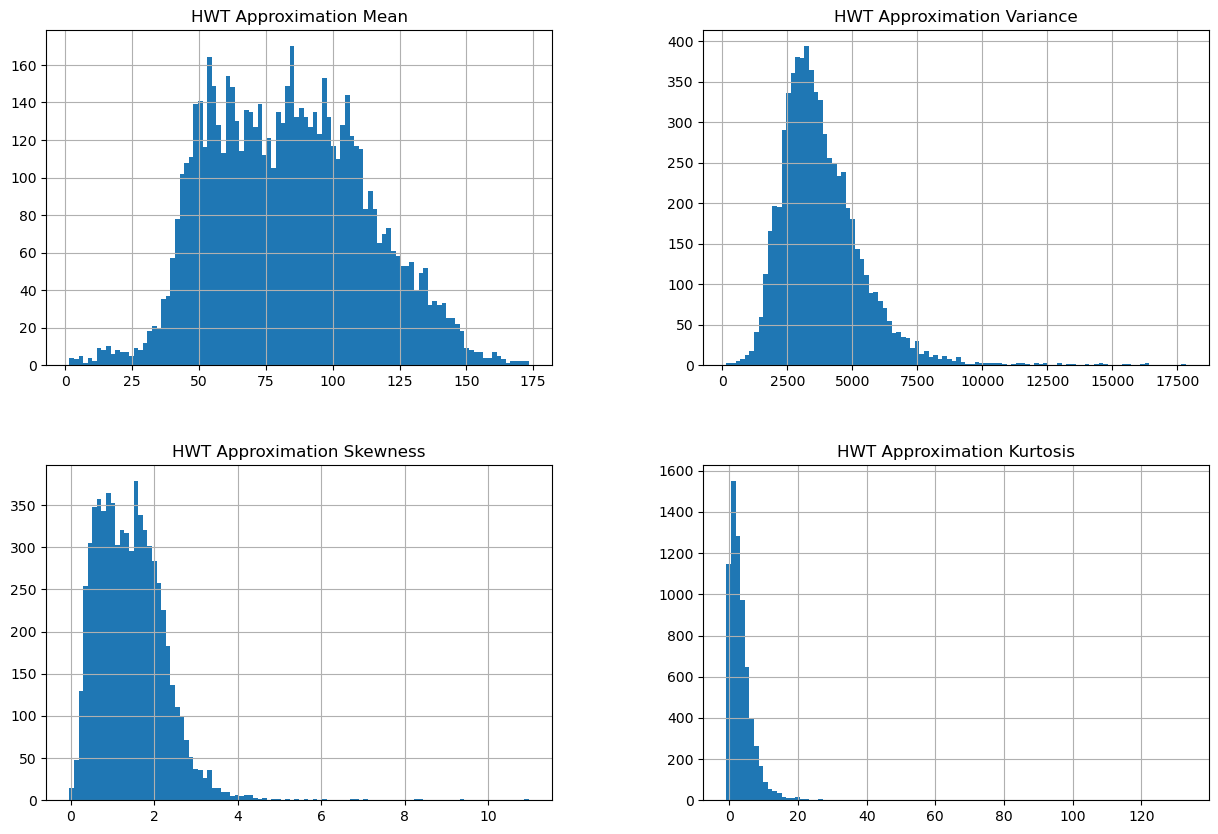

In [46]:
HWT_features = color_features[['HWT Approximation Mean', 'HWT Approximation Variance', 'HWT Approximation Skewness', 'HWT Approximation Kurtosis']]
HWT_features.hist(figsize=(15, 10), bins=100)

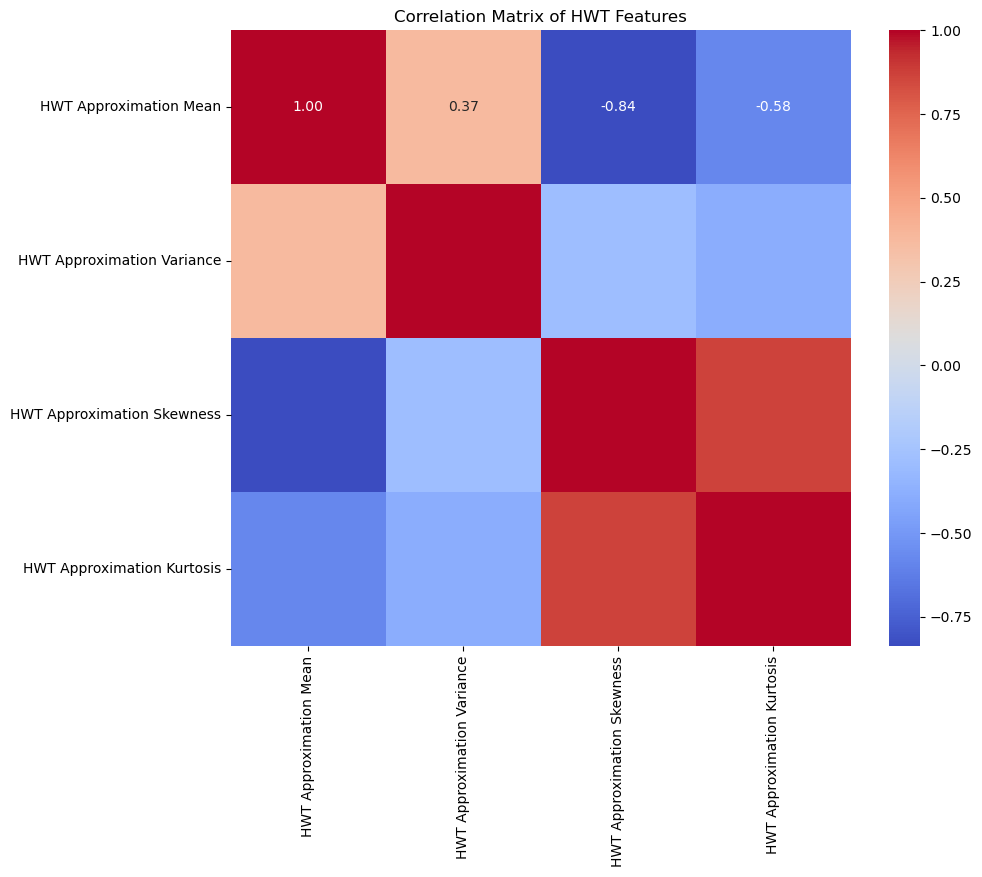

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(HWT_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of HWT Features')
plt.show()

## Noise Analysis

In [80]:
from skimage.restoration import estimate_sigma

gaussian_noise = [estimate_sigma(img.numpy(), average_sigmas=False, channel_axis=0) for img in images]

In [81]:
gaussian_noise_df = pd.DataFrame(data=gaussian_noise, columns=['Red Channel', 'Green Channel', 'Blue Channel'])
gaussian_noise_df['Overall'] = gaussian_noise_df.mean(axis=1)
gaussian_noise_df.head()

Red Channel  Green Channel  Blue Channel       Overall
0  2.749941e+00   2.675693e+00  2.649082e+00  2.691572e+00
1  1.432944e+00   1.333629e+00  1.432944e+00  1.399839e+00
2  4.568621e-33   4.568621e-33  4.568621e-33  4.568621e-33
3  2.303260e+00   2.415881e+00  2.371094e+00  2.363412e+00
4  1.796942e+00   1.735761e+00  1.700301e+00  1.744335e+00

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


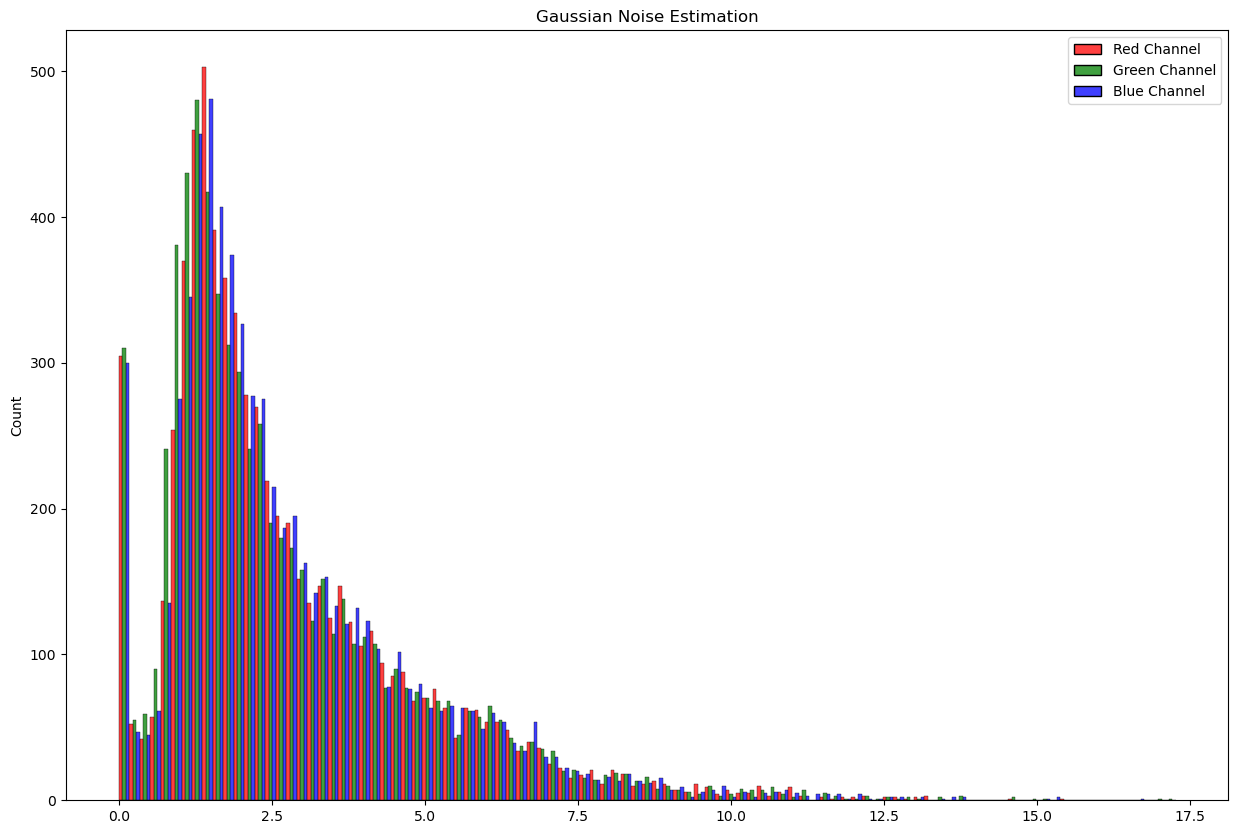

In [82]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=gaussian_noise_df[['Red Channel', 'Green Channel', 'Blue Channel']], stat='count', multiple='dodge', palette=['r', 'g', 'b'])
plt.title('Gaussian Noise Estimation')
plt.show()

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


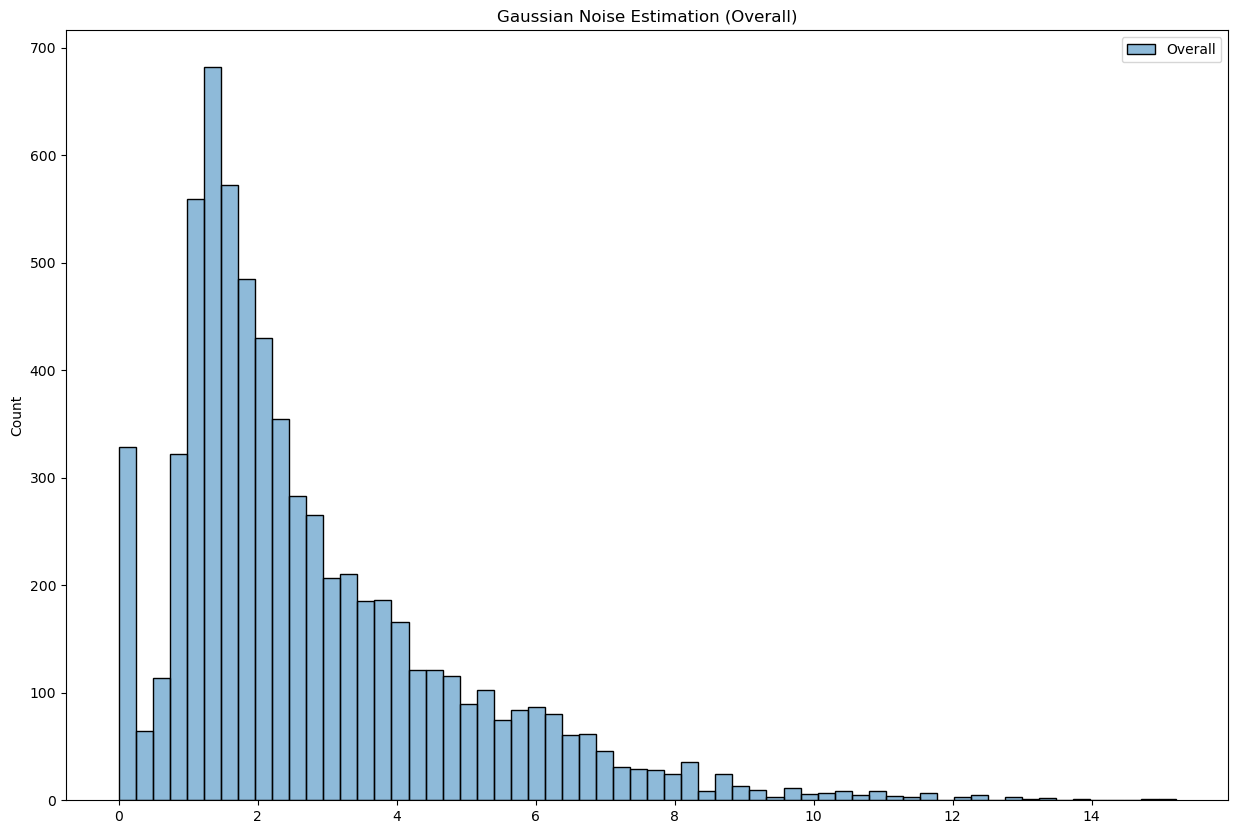

In [83]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=gaussian_noise_df[['Overall']], stat='count', color='black')
plt.title('Gaussian Noise Estimation (Overall)')
plt.show()

/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/1986476874.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_without_noise = shuffle(gaussian_noise_df[gaussian_noise_df['Red Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Blue Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Green Channel'] < guassian_noise_lower_thresh], random_state=42)
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/1986476874.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_without_noise = shuffle(gaussian_noise_df[gaussian_noise_df['Red Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Blue Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Green Channel'] < guassian_noise_lower_thresh], random_state=42)
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/1986476874.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index

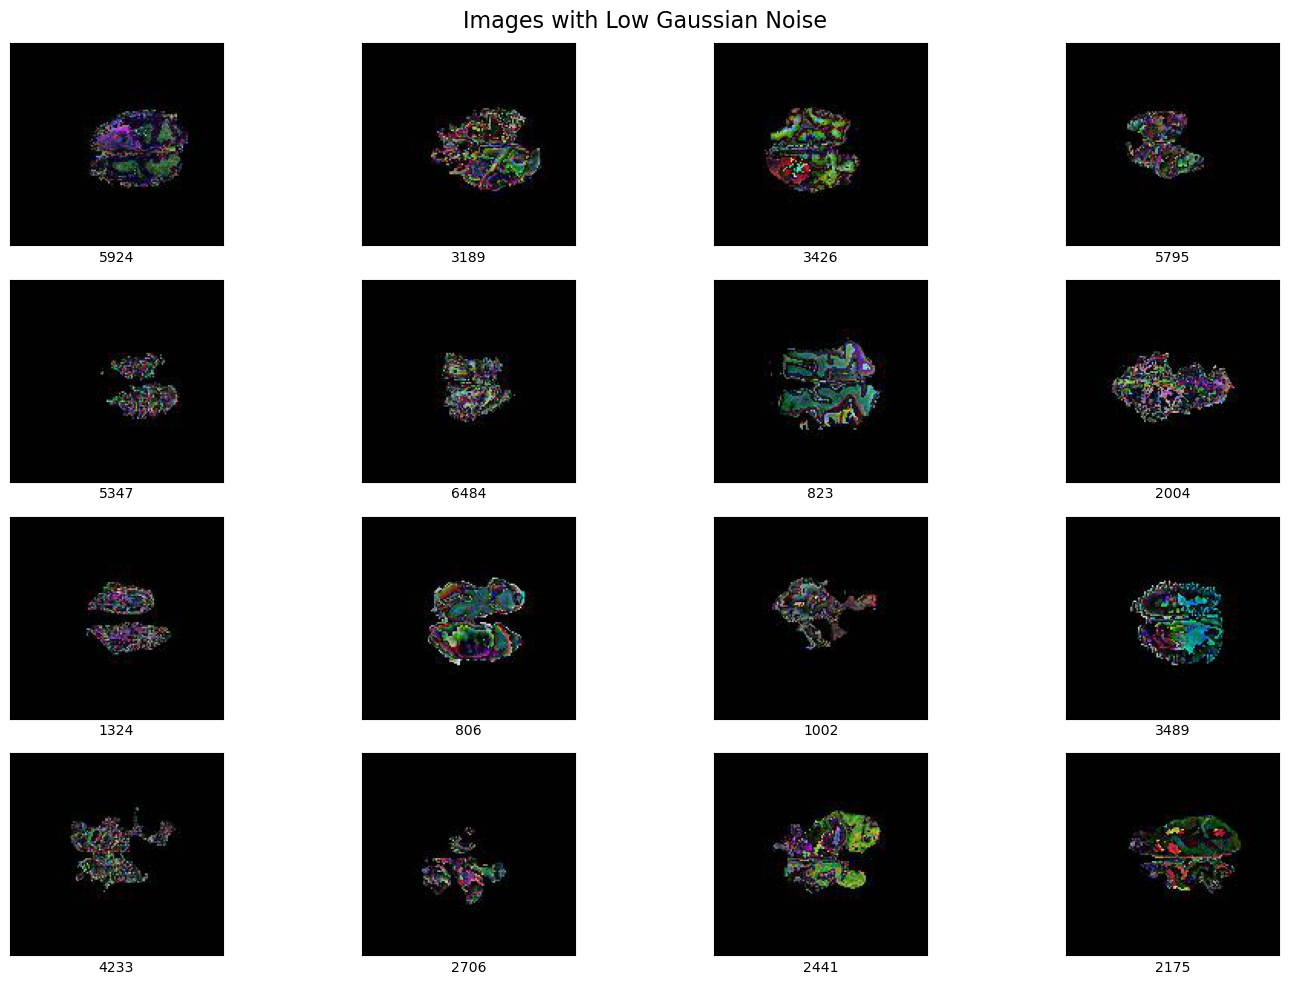

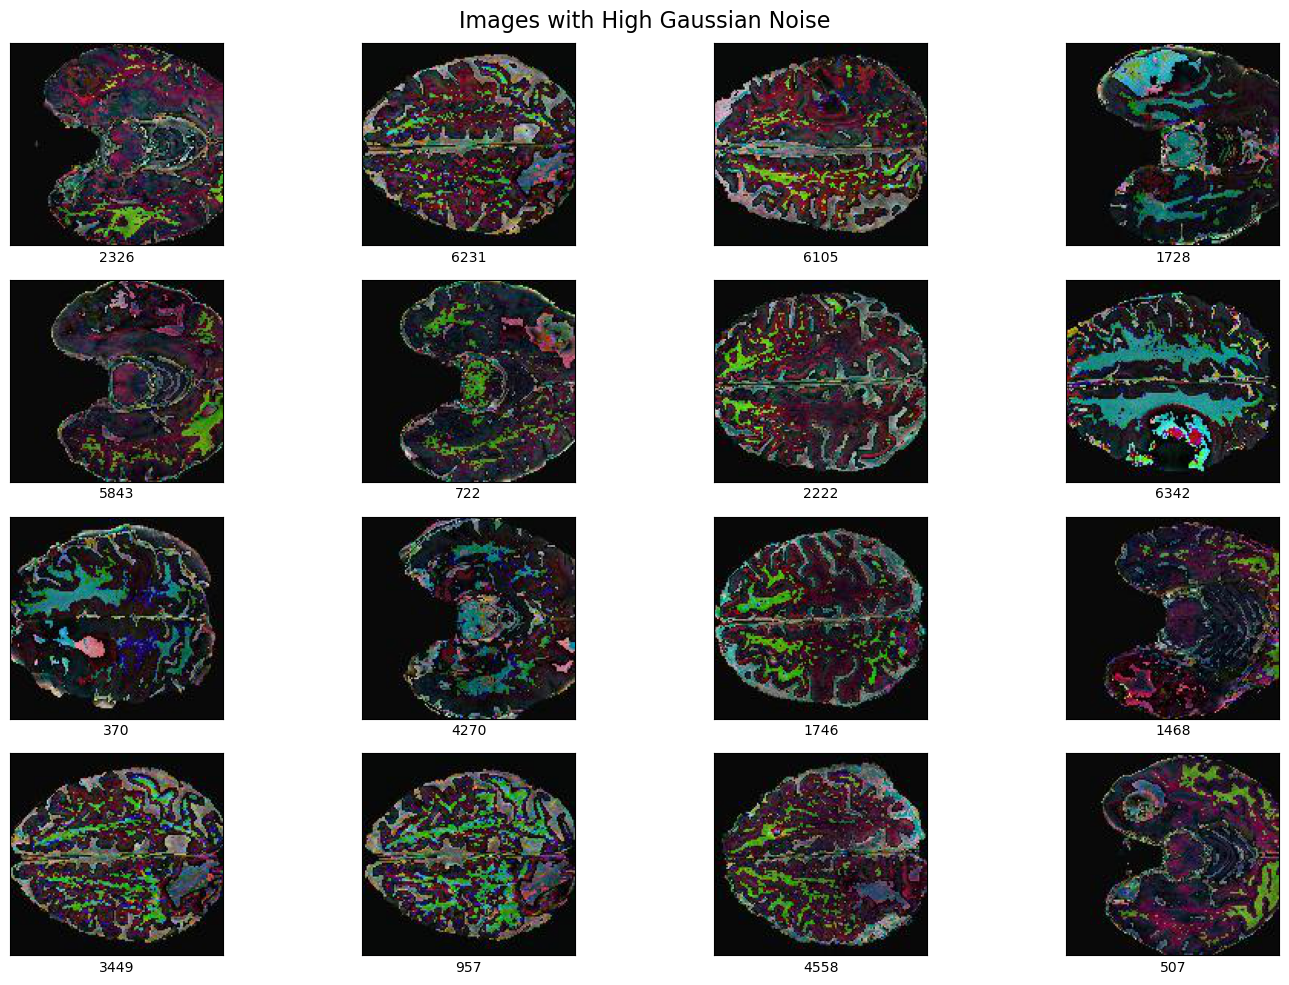

In [87]:
from sklearn.utils import shuffle

guassian_noise_lower_thresh = np.percentile(gaussian_noise_df['Overall'], 1)
guassian_noise_upper_thresh = np.percentile(gaussian_noise_df['Overall'], 99)

images_without_noise = shuffle(gaussian_noise_df[gaussian_noise_df['Red Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Blue Channel'] < guassian_noise_lower_thresh][gaussian_noise_df['Green Channel'] < guassian_noise_lower_thresh], random_state=42)
images_with_high_noise = shuffle(gaussian_noise_df[gaussian_noise_df['Red Channel'] > guassian_noise_upper_thresh][gaussian_noise_df['Blue Channel'] > guassian_noise_upper_thresh][gaussian_noise_df['Green Channel'] > guassian_noise_upper_thresh], random_state=42)
no_noise_indices = images_without_noise.head(16).index
high_noise_indices = images_with_high_noise.head(16).index

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for (i, j, current_subplot) in zip(range(16), no_noise_indices, ax.flat):    
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = Image.open(image_paths[j])
    plt.imshow(image)
    plt.xlabel(j)
    
    # TODO: add bounding boxes to check if the images are informative
fig.suptitle('Images with Low Gaussian Noise', fontsize=16)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for (i, j, current_subplot) in zip(range(16), high_noise_indices, ax.flat):    
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = Image.open(image_paths[j])
    plt.imshow(image)
    plt.xlabel(j)
    
    # TODO: add bounding boxes to check if the images are informative
fig.suptitle('Images with High Gaussian Noise', fontsize=16)
plt.tight_layout()
plt.show()

### Speckle Noise

In [88]:
import numpy as np
from scipy.ndimage import uniform_filter

def estimate_speckle_noise_channel(image, window_size=7):
    """
    Estimate speckle noise in a single channel of an image.
    
    Parameters:
    - image: Single channel of an input image as a numpy array.
    - window_size: Size of the local window to compute statistics.
    
    Returns:
    - Estimated speckle noise level for the channel.
    """
    # Ensure image is a floating point type for accurate calculations
    if image.dtype != np.float32 and image.dtype != np.float64:
        image = image.astype(np.float64)
    
    # Compute local mean
    mean = uniform_filter(image, size=window_size)
    
    # Compute local variance
    mean_sq = uniform_filter(image ** 2, size=window_size)
    variance = mean_sq - mean ** 2
    
    # Estimate noise as sqrt(mean of (variance / mean))
    noise_estimate = np.sqrt(np.mean(variance / mean))
    
    return noise_estimate

def estimate_speckle_noise_rgb(image, window_size=7):
    """
    Estimate speckle noise in an RGB image by processing each channel separately.
    
    Parameters:
    - image: Input RGB image as a numpy array of shape (H, W, 3).
    - window_size: Size of the local window to compute statistics.
    
    Returns:
    - A tuple of estimated speckle noise levels for the R, G, and B channels.
    """
    noise_levels = []
    for channel in range(3):  # Iterate over the three color channels
        channel_image = image[channel, :, :]
        noise_level = estimate_speckle_noise_channel(channel_image, window_size)
        noise_levels.append(noise_level)
    
    return tuple(noise_levels)

# Example usage:
# image = your_rgb_image_as_numpy_array
# noise_levels = estimate_speckle_noise_rgb(image)
# print("Estimated Speckle Noise Levels (R, G, B):", noise_levels)

In [89]:
speckle_noise = [estimate_speckle_noise_rgb(img.numpy()) for img in images]
speckle_noise

/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/920447165.py:27: RuntimeWarning: divide by zero encountered in divide
  noise_estimate = np.sqrt(np.mean(variance / mean))
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/920447165.py:27: RuntimeWarning: invalid value encountered in divide
  noise_estimate = np.sqrt(np.mean(variance / mean))


[(3.8018286753077946, 3.3755394582971783, 3.375273272695459),
 (3.036284049304345, 2.8266681464265933, 2.88428908485082),
 (3.7961180731278654, 3.898060582297818, 3.8751139629462736),
 (3.9096971977704986, 3.7402864076722624, 3.7195315692233297),
 (3.777412212034654, 3.778050022349135, 3.6122958998815133),
 (3.8169978770130393, 3.914042793925303, 3.6872312047525404),
 (2.66450956447467, 2.559362202812924, 2.640374909896159),
 (3.068516547754955, 2.9145313044398016, 2.99471725848072),
 (4.292208033159252, 4.555142847857556, 4.2450428039047585),
 (3.4363337043552344, 3.401071963715251, 3.283807259600757),
 (3.899881189379712, 3.7000589285731933, 3.632993801261161),
 (3.661700103025582, 3.431507858191503, 3.525855100116367),
 (4.204086478659086, 4.133566873071411, 4.087475220232196),
 (3.4437620217458607, 3.184348649666322, 3.194696761578839),
 (3.269446086201298, 3.0397949255031667, 3.0699692158936784),
 (3.5007573482882264, 3.35376982687921, 3.3729376126769117),
 (3.707854648372663, 3.4

In [90]:
gray_images = [cv2.cvtColor(img.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2GRAY) for img in images]
gray_speckle_noise = [estimate_speckle_noise_channel(img) for img in gray_images]

/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/920447165.py:27: RuntimeWarning: divide by zero encountered in divide
  noise_estimate = np.sqrt(np.mean(variance / mean))
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/920447165.py:27: RuntimeWarning: invalid value encountered in divide
  noise_estimate = np.sqrt(np.mean(variance / mean))


In [91]:
speckle_noise_df = pd.DataFrame(data=speckle_noise, columns=['Red Channel', 'Green Channel', 'Blue Channel'])
speckle_noise_df['Grayscale'] = gray_speckle_noise
speckle_noise_df.head()

Red Channel  Green Channel  Blue Channel  Grayscale
0     3.801829       3.375539      3.375273   3.345758
1     3.036284       2.826668      2.884289   2.831934
2     3.796118       3.898061      3.875114   3.737814
3     3.909697       3.740286      3.719532   3.710669
4     3.777412       3.778050      3.612296   3.665280

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


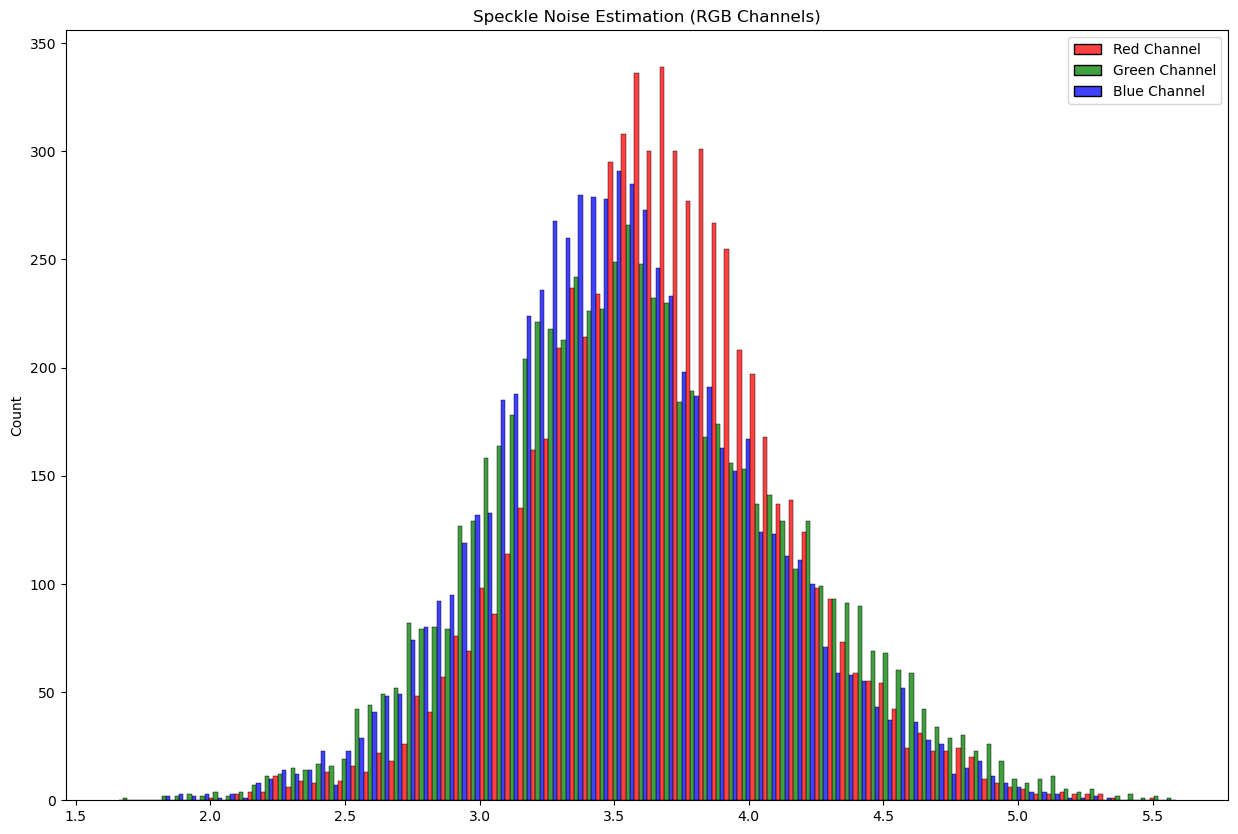

In [92]:
fix, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=speckle_noise_df[['Red Channel', 'Green Channel', 'Blue Channel']], stat='count', multiple='dodge', palette=['r', 'g', 'b'])
plt.title('Speckle Noise Estimation (RGB Channels)')
plt.show()

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


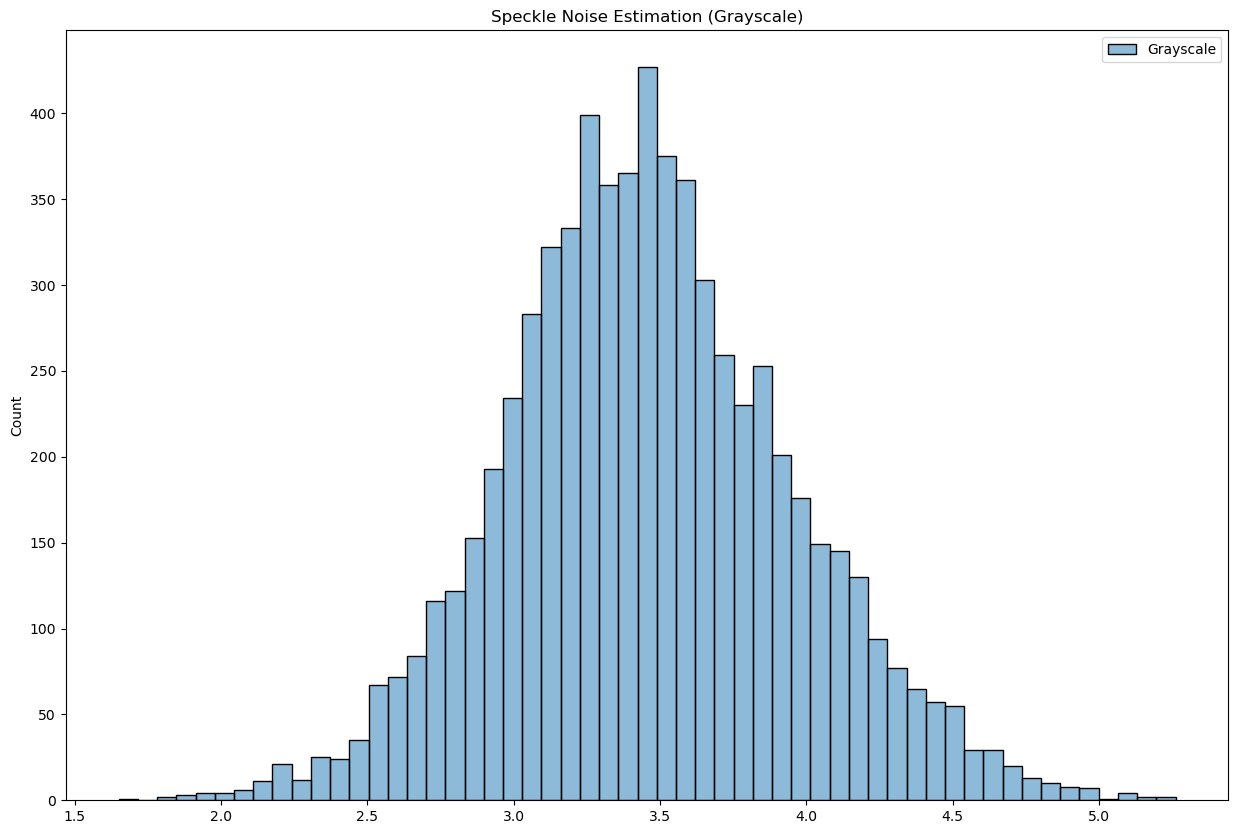

In [93]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=speckle_noise_df[['Grayscale']], stat='count', color='black')
plt.title('Speckle Noise Estimation (Grayscale)')
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 153 to 6708
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Red Channel    8 non-null      float64
 1   Green Channel  8 non-null      float64
 2   Blue Channel   2 non-null      float64
 3   Grayscale      9 non-null      float64
dtypes: float64(4)
memory usage: 920.0 bytes


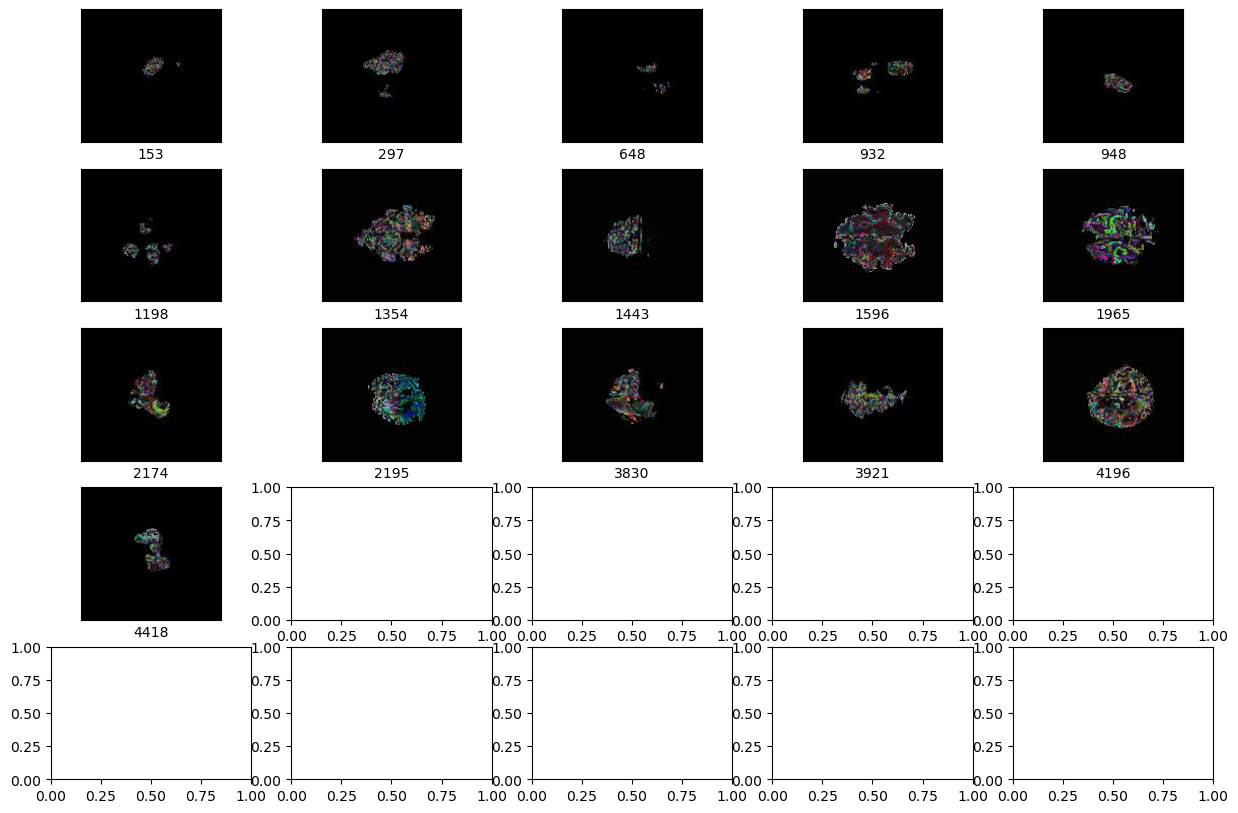

In [94]:
nan_images = speckle_noise_df[speckle_noise_df.isna().any(axis=1)]
nan_images.info()
nan_indices = nan_images.index

fig, ax = plt.subplots(5, 5, figsize=(15, 10))
for (i, j, current_subplot) in zip(range(16), nan_indices, ax.flat):    
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = Image.open(image_paths[j])
    plt.imshow(image)
    plt.xlabel(j)
    
    # TODO: add bounding boxes to check if the images are informative
plt.show()

In [95]:
red_upper_threshold = np.nanpercentile(speckle_noise_df['Red Channel'], 95)
green_upper_threshold = np.nanpercentile(speckle_noise_df['Green Channel'], 95)
blue_upper_threshold = np.nanpercentile(speckle_noise_df['Blue Channel'], 95)
gray_upper_threshold = np.nanpercentile(speckle_noise_df['Grayscale'], 95)

red_lower_threshold = np.nanpercentile(speckle_noise_df['Red Channel'], 5)
green_lower_threshold = np.nanpercentile(speckle_noise_df['Green Channel'], 5)
blue_lower_threshold = np.nanpercentile(speckle_noise_df['Blue Channel'], 5)
gray_lower_threshold = np.nanpercentile(speckle_noise_df['Grayscale'], 5)

print("Red Channel Upper Threshold:", red_upper_threshold)
print("Green Channel Upper Threshold:", green_upper_threshold)
print("Blue Channel Upper Threshold:", blue_upper_threshold)
print("Grayscale Upper Threshold:", gray_upper_threshold)
print()
print("Red Channel Lower Threshold:", red_lower_threshold)
print("Green Channel Lower Threshold:", green_lower_threshold)
print("Blue Channel Lower Threshold:", blue_lower_threshold)
print("Grayscale Lower Threshold:", gray_lower_threshold)


Red Channel Upper Threshold: 4.442872995520124
Green Channel Upper Threshold: 4.5672975813995125
Blue Channel Upper Threshold: 4.41264574409511
Grayscale Upper Threshold: 4.310296086581329

Red Channel Lower Threshold: 2.924375931425419
Green Channel Lower Threshold: 2.7235541781121153
Blue Channel Lower Threshold: 2.7361517284159302
Grayscale Lower Threshold: 2.678859419582623


If you've plotted the distribution of speckle noise levels across an RGB image and observed a Gaussian shape centered around the value of 3.5, here are some insights you can derive:

1. **Uniformity of Noise**: A Gaussian-shaped distribution of noise levels suggests that the speckle noise is relatively uniform across the image. This uniformity can simplify noise reduction techniques since you can apply the same filtering strength across the entire image.

2. **Central Value of Noise Level**: The central value (mean) of 3.5 indicates the average speckle noise level across your image. This average level gives you a baseline for evaluating the noise's impact on image quality and for designing noise reduction filters. For instance, knowing the average noise level helps in setting thresholds for denoising algorithms.

3. **Noise Intensity**: In the context of the noise level scale, a mean value of 3.5 can be interpreted based on the dynamic range of your image. If your image pixel values range from 0 to 255 (typical for 8-bit images), a noise level of 3.5 is relatively low. However, the impact also depends on the content of your image; for images with subtle features, even low-level noise can obscure important details.

4. **Standard Deviation and Noise Variation**: The spread of the Gaussian distribution (its standard deviation) indicates how much the noise level varies across the image. A narrow spread means the noise level is consistent, while a wide spread suggests significant variation. Areas with higher noise levels might require more aggressive denoising.

5. **Guidance for Noise Reduction**: Knowing the noise distribution helps in choosing and tuning noise reduction algorithms. For Gaussian-distributed noise, Gaussian filters or bilateral filters might be effective. The mean noise level of 3.5 can guide the setting of filter parameters to balance noise reduction with the preservation of image details.

6. **Evaluation of Noise Characteristics**: The Gaussian shape of the noise distribution suggests that the speckle noise in your image behaves similarly to additive Gaussian noise, despite speckle noise typically being multiplicative. This similarity might influence the choice of modeling and reduction techniques, potentially allowing for methods commonly used for Gaussian noise.

7. **Preparation for Further Analysis**: For tasks like image segmentation, classification, or feature extraction, understanding the noise level and distribution allows for better preprocessing. You can tailor your approach to ensure that noise does not unduly influence the analysis outcomes.

In summary, plotting and analyzing the speckle noise distribution provides valuable insights into the noise characteristics of your image, guiding the selection and tuning of noise reduction methods and helping to maintain or improve image quality for subsequent processing or analysis tasks.

/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/529833709.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_low_speckle_noise = shuffle(speckle_noise_df[speckle_noise_df['Red Channel'] < 2.3][speckle_noise_df['Blue Channel'] < 2.3][speckle_noise_df['Green Channel'] < 2.3], random_state=42)
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/529833709.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_low_speckle_noise = shuffle(speckle_noise_df[speckle_noise_df['Red Channel'] < 2.3][speckle_noise_df['Blue Channel'] < 2.3][speckle_noise_df['Green Channel'] < 2.3], random_state=42)
/var/folders/40/p9dn0j5n0p3372d1ncn750nm0000gn/T/ipykernel_48153/529833709.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_high_speckle_noise = shuffle(speckle_noise_df[speckle_noise_df['Red Channel'] > 4.7][speckle_noise_df['Blue Channel'] > 4.7][speckle_noi

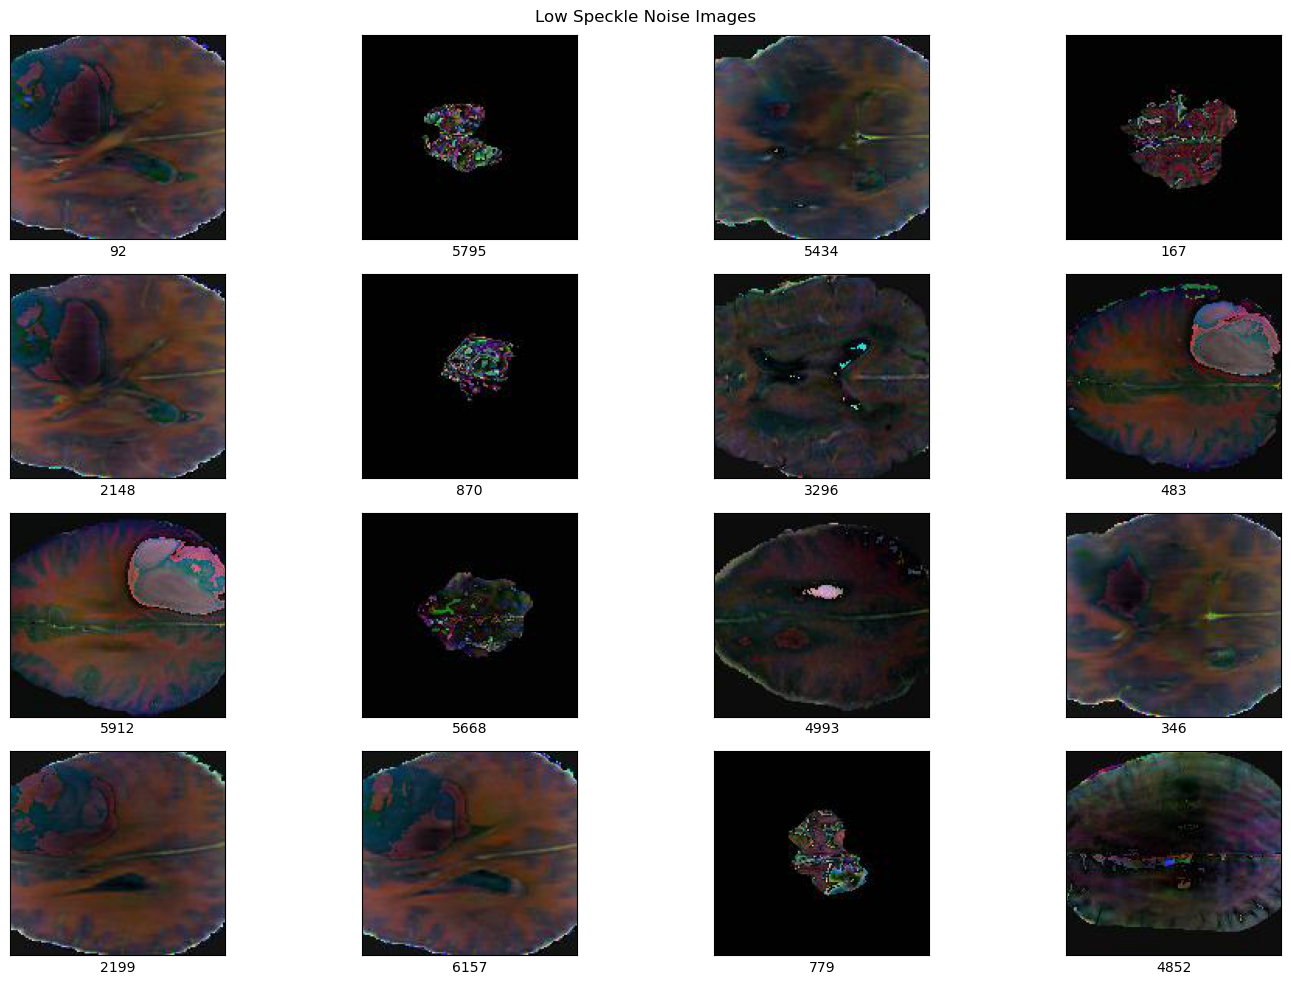

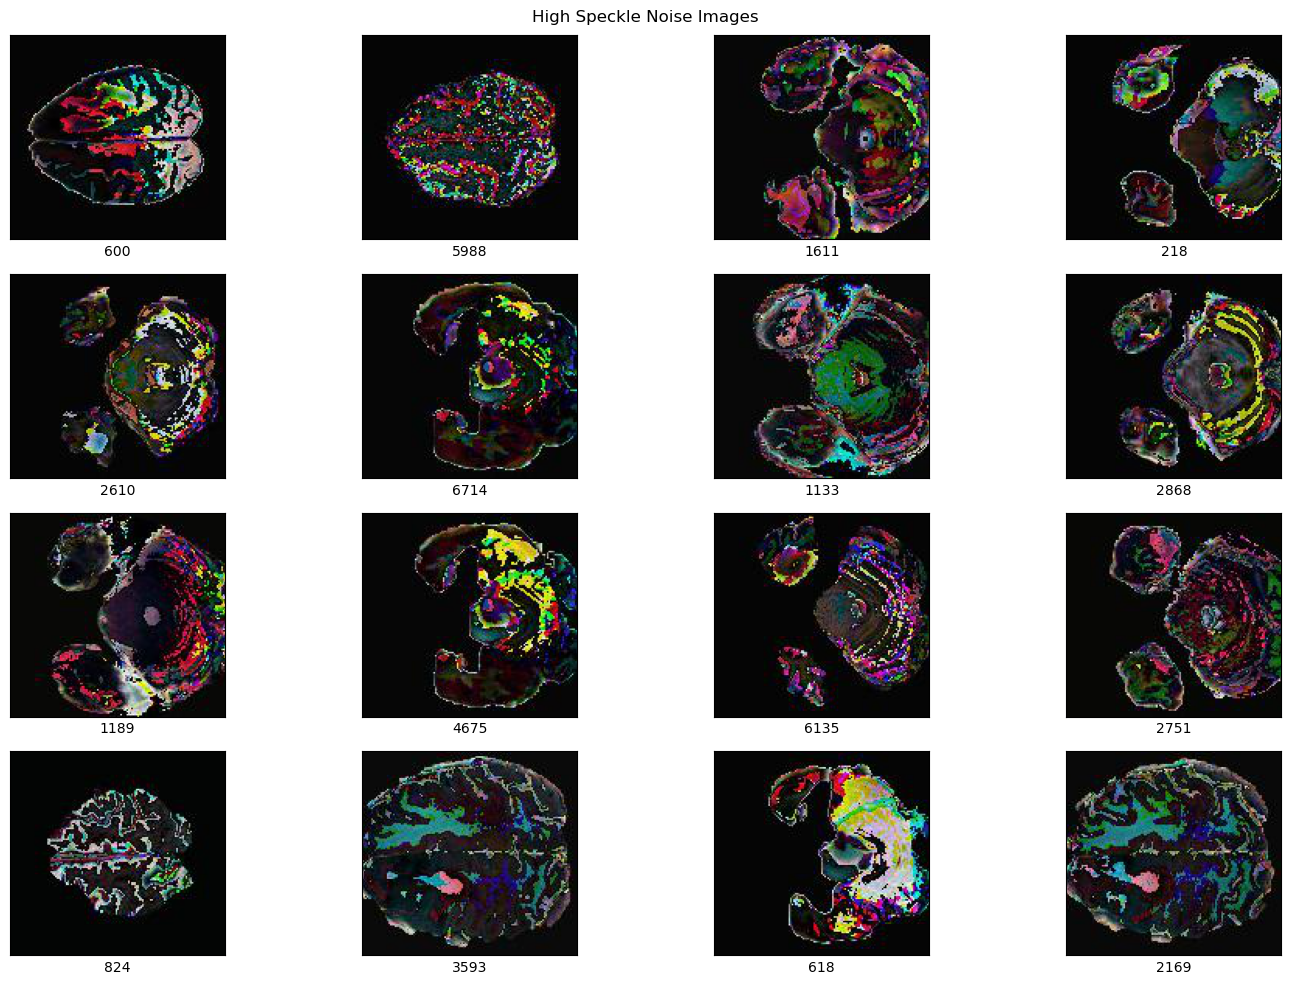

In [96]:
images_low_speckle_noise = shuffle(speckle_noise_df[speckle_noise_df['Red Channel'] < 2.3][speckle_noise_df['Blue Channel'] < 2.3][speckle_noise_df['Green Channel'] < 2.3], random_state=42)
images_high_speckle_noise = shuffle(speckle_noise_df[speckle_noise_df['Red Channel'] > 4.7][speckle_noise_df['Blue Channel'] > 4.7][speckle_noise_df['Green Channel'] > 4.7], random_state=42)
indices_low = images_low_speckle_noise.head(16).index
indices_high = images_high_speckle_noise.head(16).index

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for (i, j, current_subplot) in zip(range(16), indices_low, ax.flat):    
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = Image.open(image_paths[j])
    plt.imshow(image)
    plt.xlabel(j)
    
    # TODO: add bounding boxes to check if the images are informative
fig.suptitle('Low Speckle Noise Images')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for (i, j, current_subplot) in zip(range(16), indices_high, ax.flat):    
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = Image.open(image_paths[j])
    plt.imshow(image)
    plt.xlabel(j)
    
    # TODO: add bounding boxes to check if the images are informative
fig.suptitle('High Speckle Noise Images')
plt.tight_layout()
plt.show()